In [1]:
import numpy as np
import embedded_voting as ev
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
groups_features = np.eye(24)
groups_features[:20,:20] = np.ones(20)

noise_rescale_groups = groups_features.sum(1)/np.linalg.norm(groups_features, axis=1)
noise_rescale_groups

array([4.47213595, 4.47213595, 4.47213595, 4.47213595, 4.47213595,
       4.47213595, 4.47213595, 4.47213595, 4.47213595, 4.47213595,
       4.47213595, 4.47213595, 4.47213595, 4.47213595, 4.47213595,
       4.47213595, 4.47213595, 4.47213595, 4.47213595, 4.47213595,
       1.        , 1.        , 1.        , 1.        ])

Dans les expériences qui vont suivre, nous allons comparer différentes méthodes d'aggregations. Tout d'abord, nous comparons les méthodes "naïves" de produit des scores et somme des scores, puis nous regardons no règles basées sur la SVD (SVD Nash, SVD Sum, SVD Log et SVD Min) puis nous comparons à la règle GaussianMax (MLE Gaussian). Pour cette dernière, on utilise deux versions: Une version à froid, et une version entrainée sur 500 données. Chacune de ces règles est d'abord présentée avec et sans renormalisation des scores pour tous les algorithmes (en appliquant $f(X) = \max(0, \sqrt{\frac{X-E(x)}{\sigma(x)}})$).


Notre scenario de base est le suivant : Un groupe de 20 algorithmes corréllés et 4 groupes contenant chacun un unique algorithme.

In [2]:
n_candidates = 20
n_trys = 1000
default_group_noise = 10
default_indep_noise = 2

In [3]:
list_agg = [ev.Aggregator(rule=ev.RuleFastNash(), name="FastNash"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian()), name="MLE-1000"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleApprovalProduct()), name="Prod"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleSumRatings()), name="Sum"),
            ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleMLEGaussian()), name="MLE-0")]

rules_names = [agg.name for agg in list_agg]

# Comparaisons des règles pour ce Scenario

In [7]:
n_trys = 10000

In [8]:
groups_sizes = [20,1,1,1,1]
features = np.eye(5)
generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                      center_gap=0, 
                                                      max_scale=1,
                                                      truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                      group_noise_f=np.random.normal,
                                                      independent_noise_f=np.random.normal)

In [9]:
results_exp = np.zeros((len(list_agg)+1,n_trys))
accuracy_exp = np.zeros((len(list_agg)+1,n_trys))
results_algo = np.zeros((np.sum(groups_sizes),n_trys))
accuracy_algo = np.zeros((np.sum(groups_sizes),n_trys))
results_oracle = np.zeros(n_trys)
accuracy_oracle = np.zeros(n_trys)

for index_try in tqdm(range(n_trys)):
    ratings_training = generator(1000)
    ratings_training = np.maximum(ratings_training, 0)
    ratings_candidates = generator(n_candidates)
    ratings_candidates = np.maximum(ratings_candidates, 0)
    truth = generator.ground_truth_
    i = 20
    for agg in list_agg:
        agg.reset()
        

    ## training the MLE 500
    _ = list_agg[1](ratings_training).winner_

    welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
    # getting the results

    for k,agg in enumerate(list_agg):
        w = agg(ratings_candidates).winner_
        results_exp[k][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_exp[k][index_try] += 1
            
    w = np.random.randint(n_candidates)
    results_exp[-1][index_try] += welfare[w]
    if w == np.argmax(welfare):
        accuracy_exp[-1][index_try] += 1
        
    for j in range(np.sum(groups_sizes)):
        w = np.argmax(ratings_candidates[j])
        results_algo[j][index_try] += welfare[w]
        if w == np.argmax(welfare):
            accuracy_algo[j][index_try] += 1
            
    taboracle = np.mean(ratings_candidates[:20], 0) + np.sum(ratings_candidates[20:], 0)
    w = np.argmax(taboracle)
    results_oracle[index_try] += welfare[w]
    if w == np.argmax(welfare):
        accuracy_oracle[index_try] += 1


100%|██████████| 10000/10000 [28:19<00:00,  5.88it/s] 


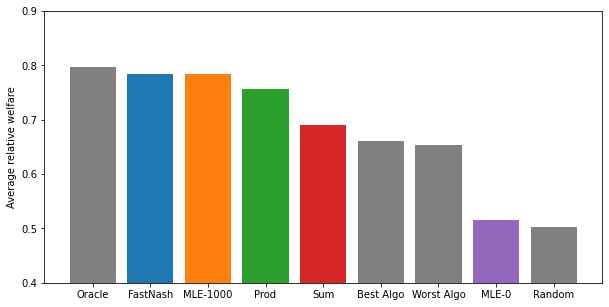

In [10]:
rules_names = [agg.name for agg in list_agg]
fig = plt.figure(figsize=(10, 5))
taborder = [1,2,3,4,7]
for i in range(len(results_exp)-1):
    plt.bar(taborder[i], results_exp.mean(1)[i])
   # plt.errorbar(taborder[i], results_exp[i], yerr=0.1, color="k")
    
plt.bar([0,8,5,6],[results_oracle.mean(),results_exp[-1].mean(),np.max(results_algo.mean(1)), np.min(results_algo.mean(1))], color="grey")
#plt.bar(np.arange(len(list_agg)+4), np.concatenate([[results_oracle],results_exp,np.array([np.max(results_algo), np.min(results_algo)])]))
plt.xticks(np.arange(len(list_agg)+4), ["Oracle", "FastNash", "MLE-1000", "Prod","Sum", "Best Algo",  "Worst Algo", "MLE-0","Random"])

plt.ylim(0.4,0.9)
plt.ylabel("Average relative welfare")
# plt.title("Mean welfare for base case scenario")
plt.show()

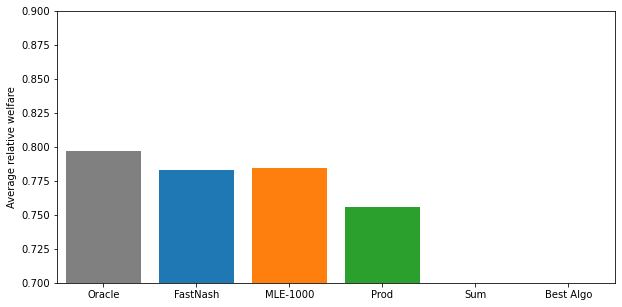

In [11]:
rules_names = [agg.name for agg in list_agg]
fig = plt.figure(figsize=(10, 5))
taborder = [1,2,3,4,7]
for i in range(len(results_exp)-1):
    plt.bar(taborder[i], results_exp.mean(1)[i])
   # plt.errorbar(taborder[i], results_exp[i], yerr=0.1, color="k")
    
plt.bar([0,8,5,6],[results_oracle.mean(),results_exp[-1].mean(),np.max(results_algo.mean(1)), np.min(results_algo.mean(1))], color="grey")
#plt.bar(np.arange(len(list_agg)+4), np.concatenate([[results_oracle],results_exp,np.array([np.max(results_algo), np.min(results_algo)])]))
plt.xticks(np.arange(len(list_agg)+4), ["Oracle", "FastNash", "MLE-1000", "Prod","Sum", "Best Algo",  "Worst Algo", "MLE-0","Random"])

plt.ylim(0.7,0.9)
plt.xlim(-0.5,5.5)
plt.ylabel("Average relative welfare")
# plt.title("Mean welfare for base case scenario")
plt.show()

(10000, 6)


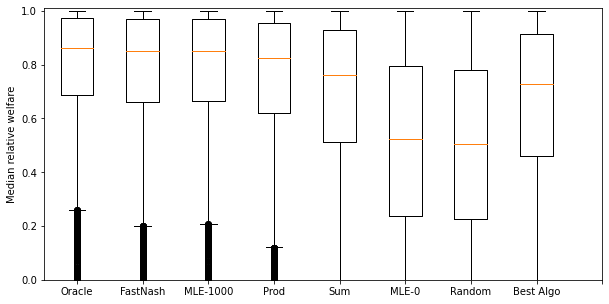

In [12]:
rules_names = [agg.name for agg in list_agg]
best_algo = np.argmax(results_algo.mean(1))
fig = plt.figure(figsize=(10, 5))
taborder = [1,2,3,5,7]

print(np.shape(results_exp.T))
plt.boxplot( np.concatenate([[results_oracle],results_exp,[results_algo[best_algo]]]).T)
plt.xticks(np.arange(1,len(list_agg)+5), ["Oracle", "FastNash", "MLE-1000", "Prod", "Sum", "MLE-0", "Random", "Best Algo"])

plt.ylim(0,1.01)
plt.ylabel("Median relative welfare")
#plt.title("Median welfare for base case scenario")
plt.show()

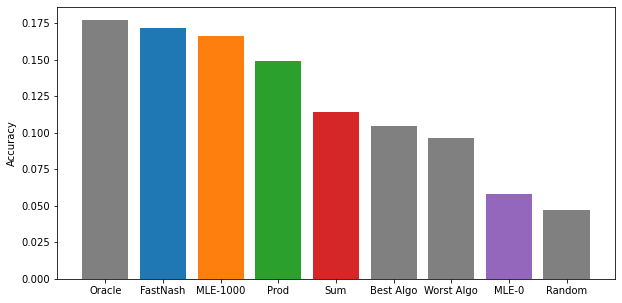

In [13]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))

taborder = [1,2,3,4,7]
for i in range(len(results_exp)-1):
    plt.bar(taborder[i], accuracy_exp.mean(1)[i])
   # plt.errorbar(taborder[i], results_exp[i], yerr=0.1, color="k")
    
plt.bar([0,8,5,6],[accuracy_oracle.mean(),accuracy_exp[-1].mean(),np.max(accuracy_algo.mean(1)), np.min(accuracy_algo.mean(1))], color="grey")
#plt.bar(np.arange(len(list_agg)+4), np.concatenate([[results_oracle],results_exp,np.array([np.max(results_algo), np.min(results_algo)])]))
plt.xticks(np.arange(len(list_agg)+4), ["Oracle", "FastNash", "MLE-1000", "Prod","Sum", "Best Algo",  "Worst Algo", "MLE-0","Random"])


# plt.bar(np.arange(len(list_agg)+4), np.concatenate([[accuracy_oracle],accuracy_exp,np.array([np.max(accuracy_algo), np.min(accuracy_algo)])]))
# plt.xticks(np.arange(len(list_agg)+4), ["Oracle"]+rules_names+["Random", "Best Algo", "Worst Algo"])

plt.ylabel("Accuracy")
#plt.title("Accuracy for base case scenario")
plt.show()

In [14]:
np.savetxt("basecase_welfare_main.csv", np.concatenate([results_exp,[results_oracle]]), delimiter=",")
np.savetxt("basecase_accuracy_main.csv", np.concatenate([accuracy_exp,[accuracy_oracle]]), delimiter=",")
np.savetxt("basecase_welfare_algo.csv", results_algo, delimiter=",")
np.savetxt("basecase_accuracy_algo.csv", accuracy_algo, delimiter=",")

# La taille du groupe homogéne

Dans cette section, nous faisons varier la taille du groupe homogéne entre 1 et 30 et nous regardons l'impact que cela a sur les règles

In [16]:
n_trys=1000

In [17]:
groups_sizes = [30,1,1,1,1]
features = np.eye(5)
generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                      center_gap=0, 
                                                      max_scale=1,
                                                      truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                      group_noise_f=np.random.normal,
                                                      independent_noise_f=np.random.normal)

In [19]:

list_val = [1] + list(range(2,31,2))
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))

for _ in tqdm(range(n_trys)):
    ratings_training = generator(500)
    ratings_training = np.maximum(ratings_training, 0)
    ratings_candidates = generator(n_candidates)
    ratings_candidates = np.maximum(ratings_candidates, 0)
    truth = generator.ground_truth_
    for j in range(len(list_val)):
        i = list_val[j]
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        _ = list_agg[1]( ratings_training[30-i:]).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates[30-i:]).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [08:58<00:00,  1.86it/s]


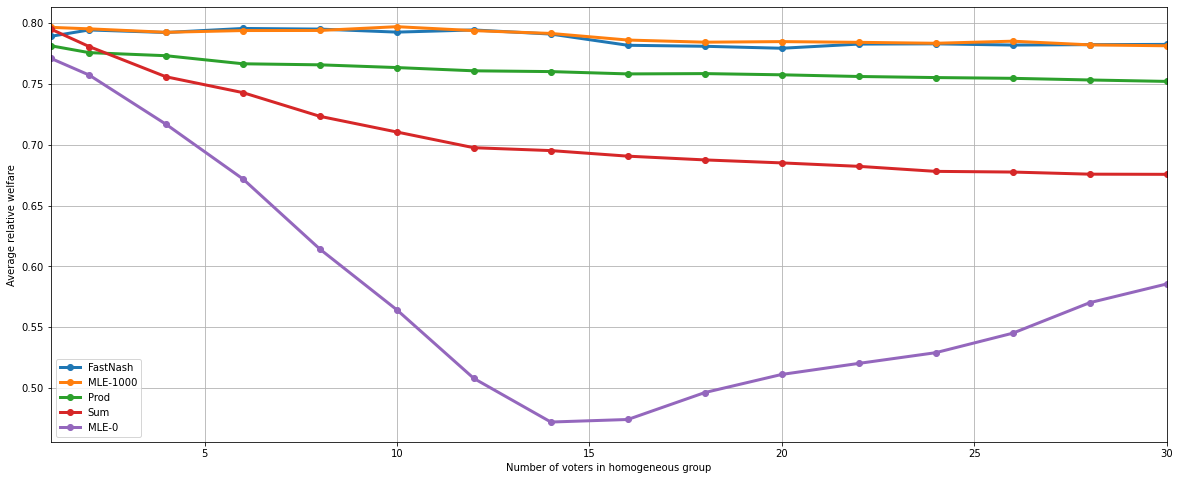

In [22]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(1,30)
plt.xlabel("Number of voters in homogeneous group")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with number of voters in group 1")
plt.legend()
plt.grid(0.3)
plt.show()

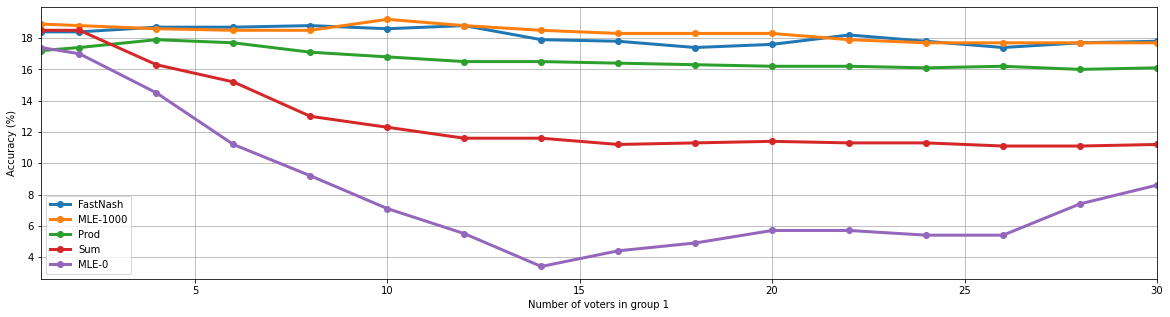

In [23]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, 100*r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(1,30)
plt.xlabel("Number of voters in group 1")
plt.ylabel("Accuracy (%)")
# plt.title("Evolution of the welfare with number of voters in group 1")
plt.legend()
plt.grid(0.3)
plt.show()

# Le nombre de groupes uniques

Dans cette section, nous faisons varier le nombre de groupe contenant un algorithme unique entre 1 et 20

In [24]:
groups_sizes = [20] + [1]*20
features = np.eye(21)
generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                            center_gap=0, 
                                                            max_scale=1,
                                                            truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                            group_noise_f=np.random.normal,
                                                            independent_noise_f=np.random.normal)

In [25]:
list_val = range(0,21,2)
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))

for _ in tqdm(range(n_trys)):
    ratings_training = generator(500)
    ratings_training = np.maximum(ratings_training, 0)
    ratings_candidates = generator(n_candidates)
    ratings_candidates = np.maximum(ratings_candidates, 0)
    truth = generator.ground_truth_
    for j in range(len(list_val)):
        i = list_val[j]
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        _ = list_agg[1]( ratings_training[:20+i]).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates[:20+i]).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [08:54<00:00,  1.87it/s]


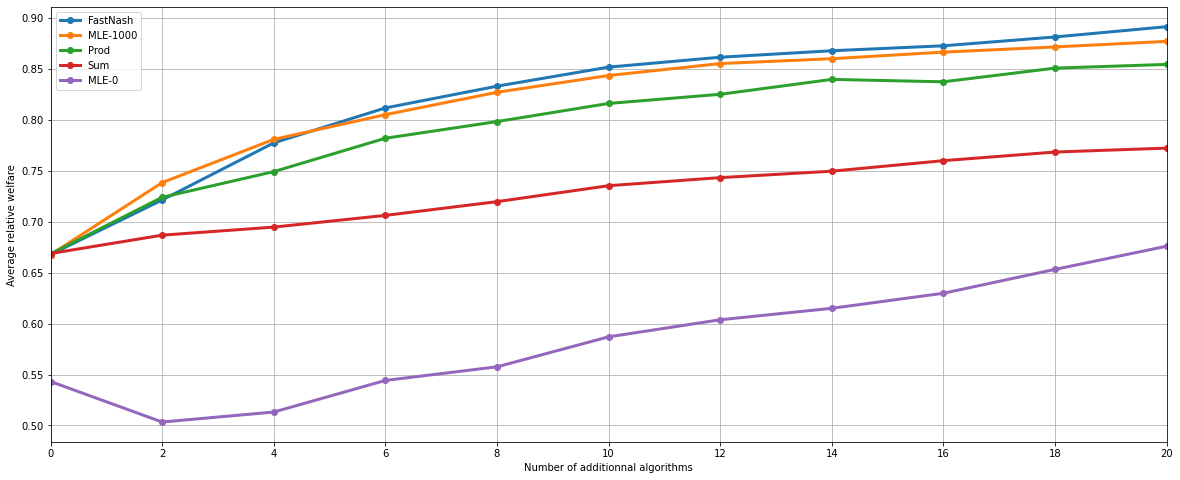

In [26]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xticks(range(0,21,2), range(0,21,2))
plt.xlim(0,20)
plt.xlabel("Number of additionnal algorithms")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with number of groups")
plt.legend()
plt.grid(0.3)
plt.show()
    

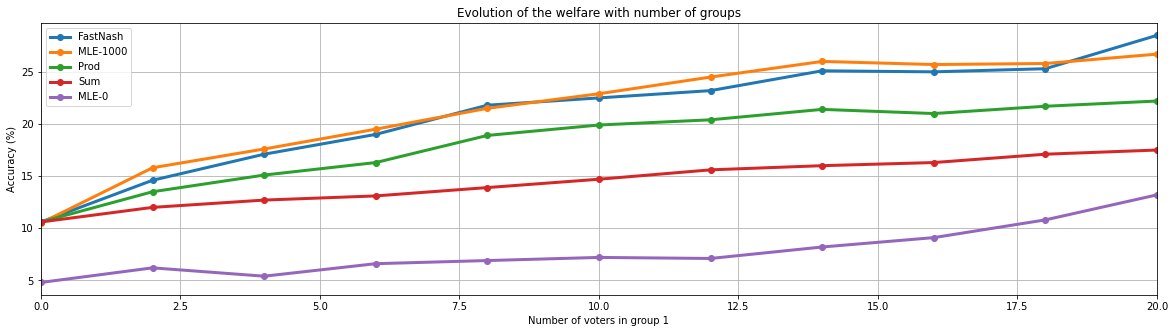

In [27]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, 100*r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(0,20)
plt.xlabel("Number of voters in group 1")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of the welfare with number of groups")
plt.legend()
plt.grid(0.3)
plt.show()

# Le nombre de candidats

Dans cette section, nous faisons varier le nombre de candidats à l'élection entre 5 et 50

In [28]:
groups_sizes = [20,1,1,1,1]
features = np.eye(5)
generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                      center_gap=0, 
                                                      max_scale=1,
                                                      truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                      group_noise_f=np.random.normal,
                                                      independent_noise_f=np.random.normal)

In [29]:
list_val = range(2,51,5)
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))

for _ in tqdm(range(n_trys)):
    ratings_training = generator(500)
    ratings_training = np.maximum(ratings_training, 0)
    ratings_candidates = generator(50)
    ratings_candidates = np.maximum(ratings_candidates, 0)
    truth = generator.ground_truth_
    for j in range(len(list_val)):
        i = list_val[j]
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        _ = list_agg[1](ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth[:i]])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates[:,:i]).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [07:28<00:00,  2.23it/s]


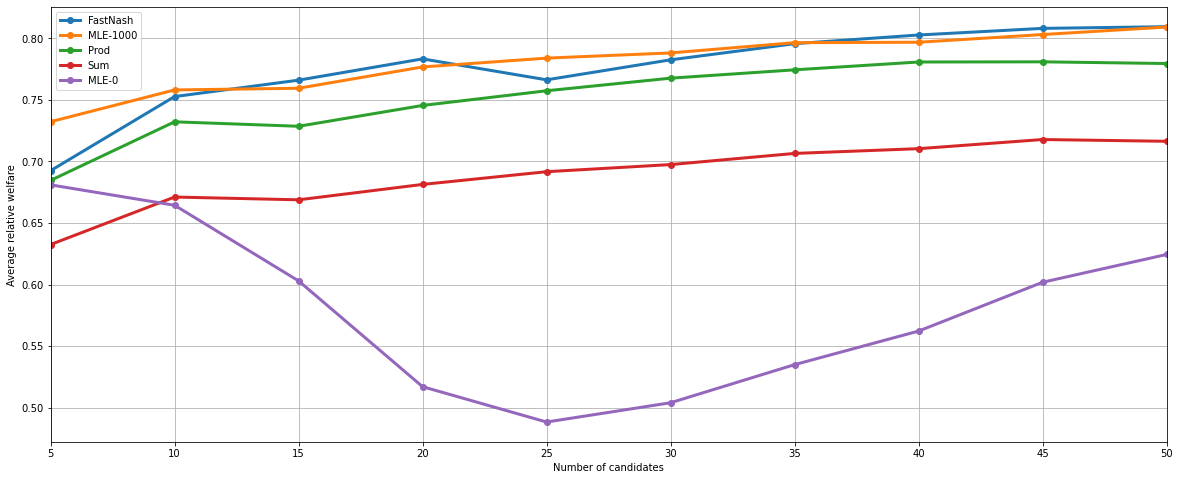

In [30]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(5,50)
plt.xlabel("Number of candidates")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with number of candidates")
plt.legend()
plt.grid(0.3)
plt.show()
    

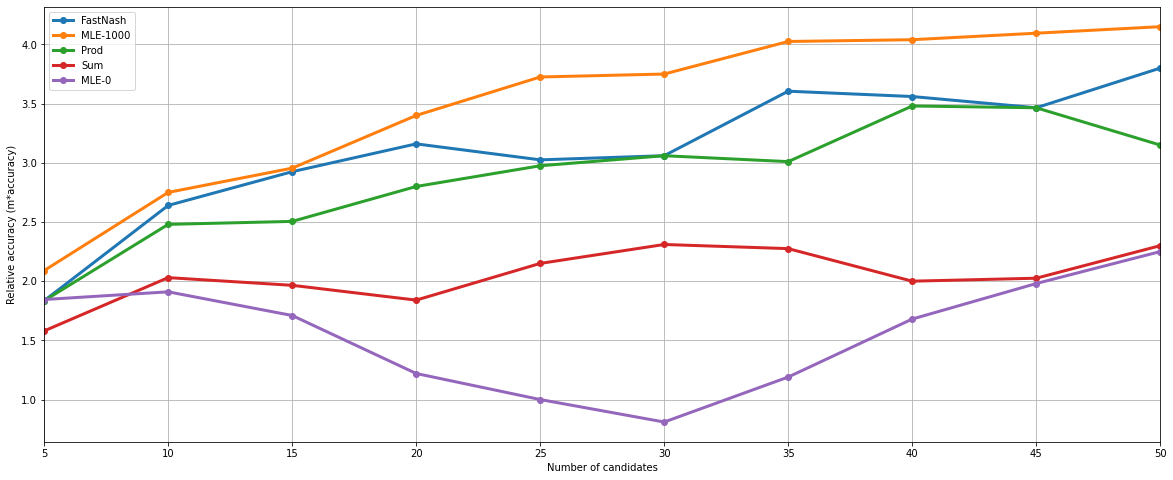

In [31]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, [list_val[i]*r[i] for i in range(len(list_val))], 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(5,50)
plt.xlabel("Number of candidates")
plt.ylabel("Relative accuracy (m*accuracy)")
# plt.title("Evolution of the accuracy with number of candidates")
plt.legend()
plt.grid(0.3)
plt.show()

# Nombre de dimension du groupe corréllé [DEPRECATED]

On peut imaginer qu'il a + de 1 dimensions (entre 1 et 5)

In [32]:
def create_generator_dim(dim=1):
    groups_sizes = [1]*24
    features = np.zeros((24, dim+4))
    features[20:,dim:] = np.eye(4)
    features[:20,:dim] = np.random.rand()
    return ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                     features, 
                                                     group_noise=8, 
                                                     independent_noise=2,
                                                     center_gap=0, 
                                                     max_scale=1,
                                                     truth_generator=ev.TruthGeneratorUniform(seed=np.random.randint(100000)),
                                                     group_noise_f=np.random.normal,
                                                     independent_noise_f=np.random.normal)

In [33]:
list_val = range(1,6)
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))


for _ in tqdm(range(n_trys)):
    for j in range(len(list_val)):
        i = list_val[j]
        generator  = create_generator_dim(i)
        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        _ = list_agg[-1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [04:42<00:00,  3.54it/s]


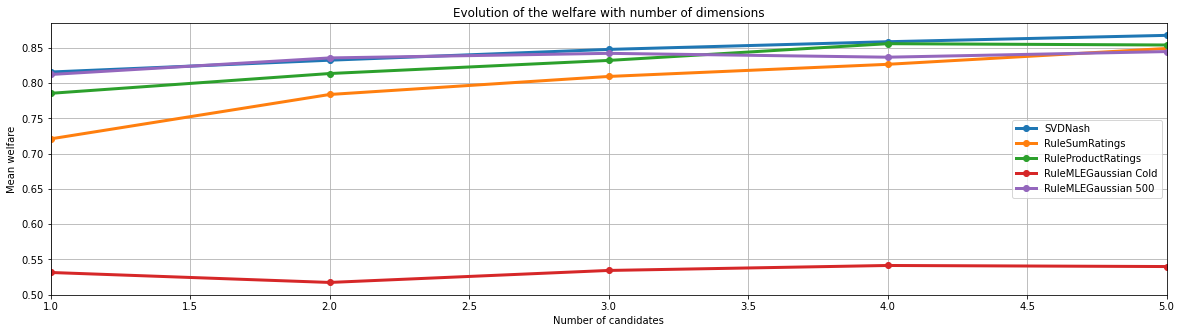

In [34]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(1,5)
plt.xlabel("Number of candidates")
plt.ylabel("Mean welfare")
plt.title("Evolution of the welfare with number of dimensions")
plt.legend()
plt.grid(0.3)
plt.show()

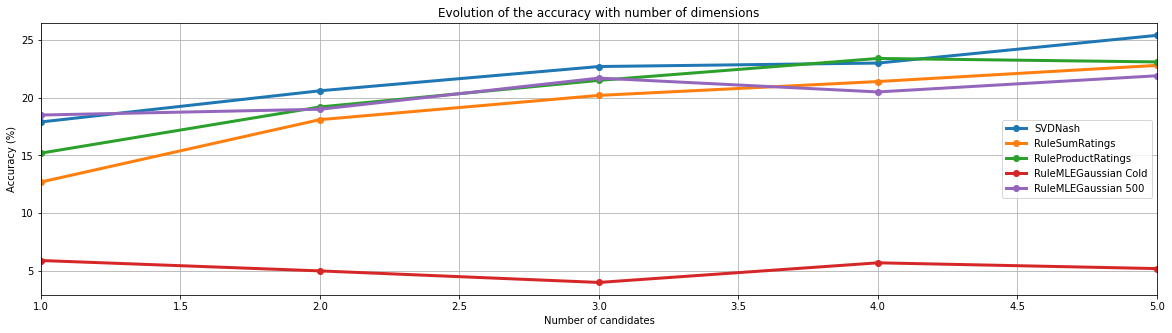

In [35]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, 100*r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(1,5)
plt.xlabel("Number of candidates")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of the accuracy with number of dimensions")
plt.legend()
plt.grid(0.3)
plt.show()

# Le bruit de groupe

In [43]:
n_trys = 1000

In [44]:
def create_generator_gnoise(gnoise=1):
    groups_sizes = [20, 1, 1, 1, 1]
    features = np.eye(5)
    return ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=gnoise, 
                                                      independent_noise=default_indep_noise,
                                                     center_gap=0, 
                                                     max_scale=1,
                                                     truth_generator=ev.TruthGeneratorUniform(seed=np.random.randint(100000)),
                                                     group_noise_f=np.random.normal,
                                                     independent_noise_f=np.random.normal)

In [45]:
list_val = range(0,21,2)
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))


for _ in tqdm(range(n_trys)):
    for j in range(len(list_val)):
        i = list_val[j]
        generator  = create_generator_gnoise(i)
        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        _ = list_agg[-1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [09:27<00:00,  1.76it/s]


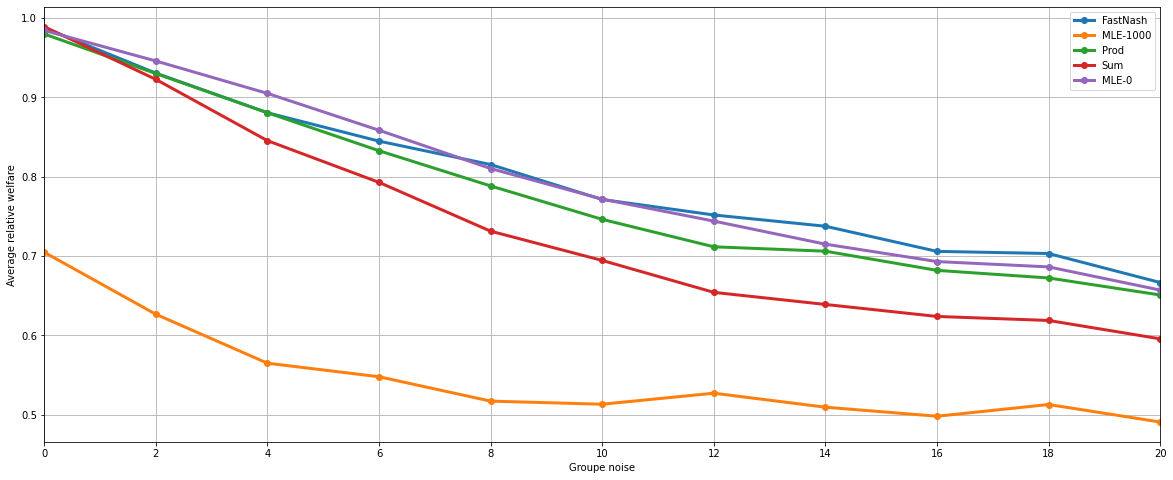

In [50]:

_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(0,20)
plt.xticks(range(0,21,2),range(0,21,2))
plt.xlabel("Groupe noise")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with group noise")
plt.legend()
plt.grid(0.3)
plt.show()

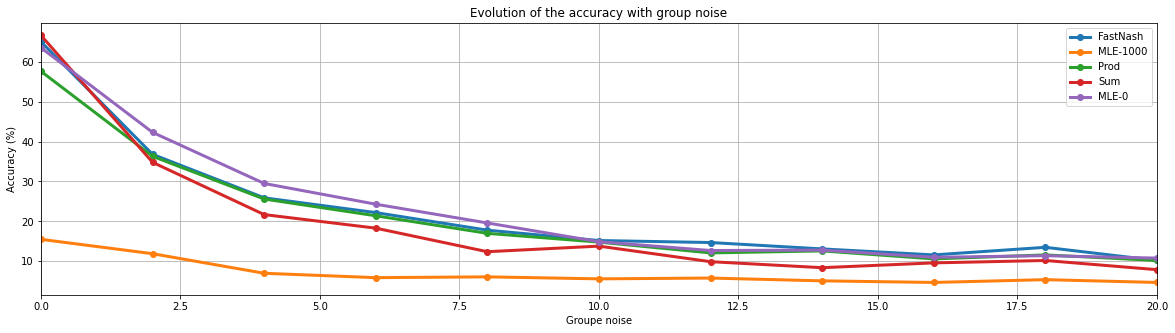

In [51]:

_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, 100*r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(0, 20)
plt.xlabel("Groupe noise")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of the accuracy with group noise")
plt.legend()
plt.grid(0.3)
plt.show()

# Le bruit individuel

In [4]:
def create_generator_inoise(inoise=2):
    groups_sizes = [20, 1, 1, 1, 1]
    features = np.eye(5)
    return ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=inoise,
                                                     center_gap=0, 
                                                     max_scale=1,
                                                     truth_generator=ev.TruthGeneratorUniform(seed=np.random.randint(100000)),
                                                     group_noise_f=np.random.normal,
                                                     independent_noise_f=np.random.normal)

In [5]:
n_trys = 10000

In [6]:
#list_val = [0,1] + list(range(2,21,2))
list_val = np.linspace(0,0.1,10)
results_exp = np.zeros((len(list_val),len(list_agg)))
accuracy_exp = np.zeros((len(list_val),len(list_agg)))
n_trys = 1

for _ in tqdm(range(n_trys)):
    for j in range(len(list_val)):
        i = list_val[j]
        generator  = create_generator_inoise(i)
        #ratings_training = generator(500)
        #ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        
        for agg in list_agg:
            agg.reset()
        

        ## training the MLE 500
        #_ = list_agg[1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        results_i = []
        for k,agg in enumerate(list_agg[-1:]):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

[[ 0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695 -0.02150599 -0.00900655  0.00242289 -0.00699652]
 [ 0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695 -0.02150599 -0.00900655  0.00242289 -0.00699652]
 [ 0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695 -0.02150599 -0.00900655  0.00242289 -0.00699652]
 [ 0.00300695  0.00300695  0.00300695  0.00300695  0.00300695  0.00300695
   0.00300695  0.00300695  0.003006

In [12]:
results_exp

array([[0.77162092, 0.        , 0.        , 0.        , 0.        ],
       [0.53821347, 0.        , 0.        , 0.        , 0.        ],
       [0.52419496, 0.        , 0.        , 0.        , 0.        ],
       [0.53789571, 0.        , 0.        , 0.        , 0.        ],
       [0.51589543, 0.        , 0.        , 0.        , 0.        ],
       [0.53970397, 0.        , 0.        , 0.        , 0.        ],
       [0.53179994, 0.        , 0.        , 0.        , 0.        ],
       [0.51650829, 0.        , 0.        , 0.        , 0.        ],
       [0.53611779, 0.        , 0.        , 0.        , 0.        ],
       [0.51659053, 0.        , 0.        , 0.        , 0.        ]])

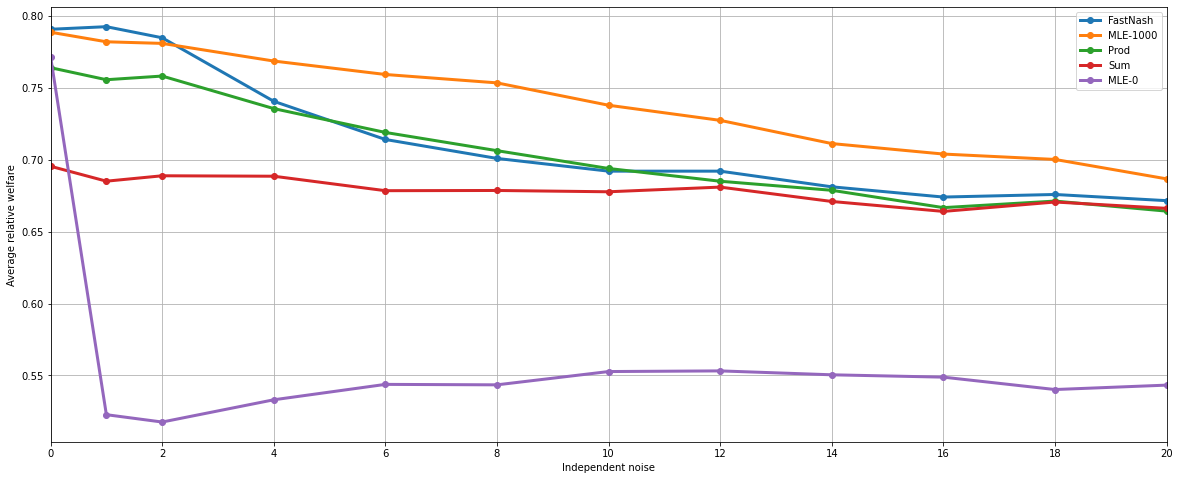

In [55]:

_ = plt.figure(figsize=(20, 8))
for i, r in enumerate(results_exp.T):
    plt.plot(list_val, r, 'o-', label=rules_names[i], linewidth=3)
    
plt.xticks(range(0,21,2), range(0,21,2))

#plt.ylim(0.8, 1)
plt.xlim(0,20)
plt.xlabel("Independent noise")
plt.ylabel("Average relative welfare")
# plt.title("Evolution of the welfare with indepedent noise")
plt.legend()
plt.grid(0.3)
plt.show()

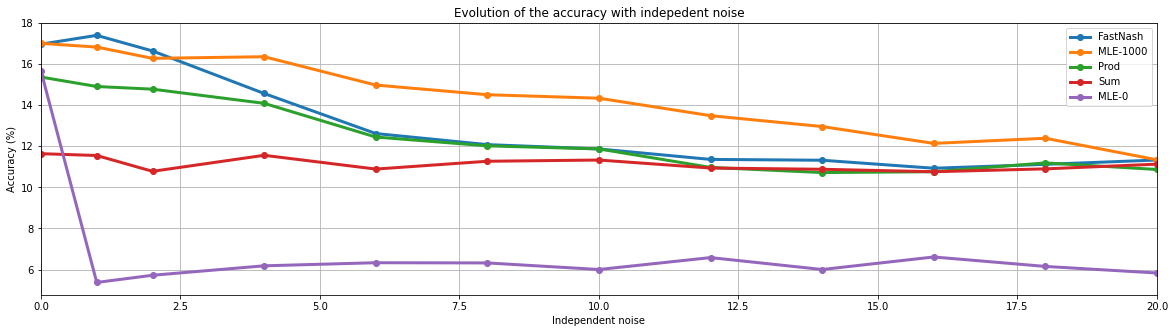

In [57]:

_ = plt.figure(figsize=(20, 5))
for i, r in enumerate(accuracy_exp.T):
    plt.plot(list_val, 100*r, 'o-', label=rules_names[i], linewidth=3)

#plt.ylim(0.8, 1)
plt.xlim(0,20)
plt.xlabel("Independent noise")
plt.ylabel("Accuracy (%)")
plt.title("Evolution of the accuracy with indepedent noise")
plt.legend()
plt.grid(0.3)
plt.show()

# Fonction de bruit de groupe

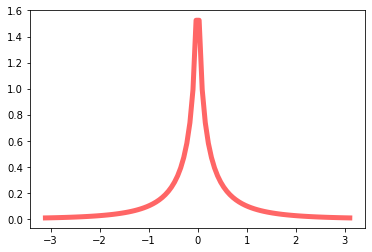

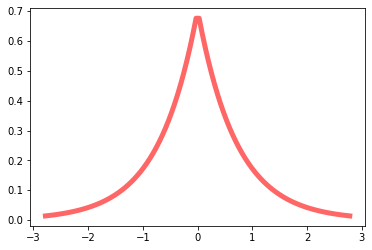

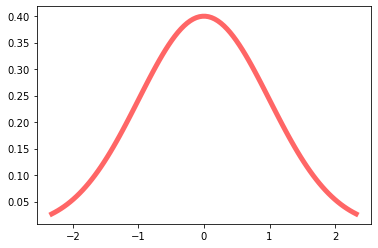

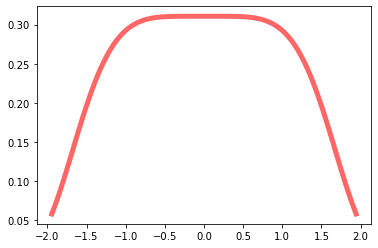

In [109]:
from scipy.stats import gennorm

def create_gennorm(beta=1):
    std = gennorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    def f1(size):
        return gennorm.rvs(beta, scale=scale, size=size)
    return f1


def plot_gennorm(beta=1):
    std = gennorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(gennorm.ppf(0.01, beta, scale=scale),

                    gennorm.ppf(0.99, beta, scale=scale), 100)

    ax.plot(x, gennorm.pdf(x, beta, scale=scale),

           'r-', lw=5, alpha=0.6, label='gennorm pdf')


    plt.show()
    
    
for x in [0.5,1,2,5]:
    plot_gennorm(x)

1.6099993626672797 1.0134727053937977


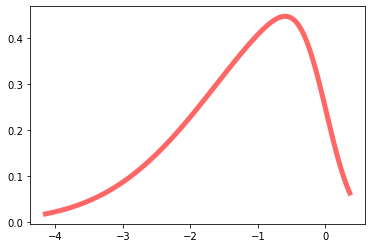

1.6089340238229126 1.0081387103005552


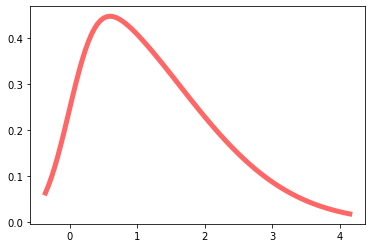

In [112]:
from scipy.stats import skewnorm

def create_skewnorm(beta=1):
    std = skewnorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    def f1(size):
        return skewnorm.rvs(beta, scale=scale, size=size)
    return f1


def plot_skewnorm(beta=1):
    std = skewnorm.rvs(beta, scale=1, size=100000).std()
    scale = 1/std
    fig, ax = plt.subplots(1, 1)
    x = np.linspace(skewnorm.ppf(0.01, beta, scale=scale),

                    skewnorm.ppf(0.99, beta, scale=scale), 100)

    ax.plot(x, skewnorm.pdf(x, beta, scale=scale),

           'r-', lw=5, alpha=0.6, label='gennorm pdf')

    print(scale, skewnorm.rvs(beta, scale=scale, size=10000).std())

    plt.show()
    
    
for x in [-5,5]:
    plot_skewnorm(x)

0.9973486477543276


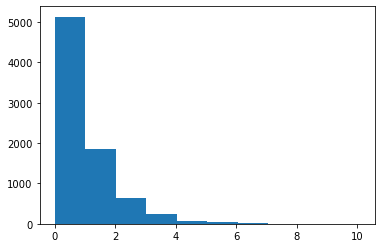

0.9896164148845147


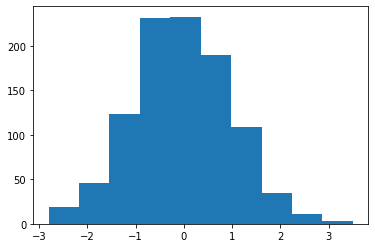

0.9698143978809186


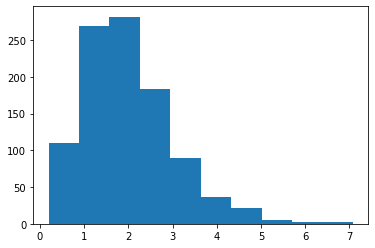

1.0120476892653925


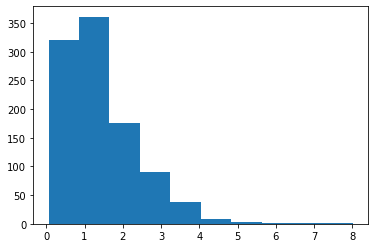

1.0264576703946477


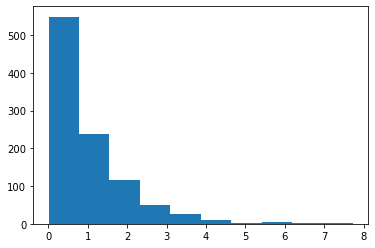

In [113]:
def f1(size):
    return np.random.normal(0,1,size)
def f2(size):
    return np.random.gamma(4,1/2,size)
def f3(size):
    return np.random.gamma(2,1/np.sqrt(2),size)
def f4(size):
    return np.random.exponential(1,size)

list_bruits = [f1, create_gennorm(0.5), create_gennorm(5), create_skewnorm(-5), create_skewnorm(5)]
bruits_name = ["Normal", "GenNorm(0.5)", "GenNorm(5)", "SkewNorm(-5)", "SkewNorm(5)"]


plt.hist(np.random.standard_exponential((8000)))
print(np.random.standard_exponential((8000)).std())
plt.show()



plt.hist(np.random.normal(0,1,1000))
print(np.random.normal(0,1,1000).std())
plt.show()

plt.hist(np.random.gamma(4,1/2,1000))
print(np.random.gamma(4,1/2,1000).std())
plt.show()


plt.hist(np.random.gamma(2,1/np.sqrt(2),1000))
print(np.random.gamma(2,1/np.sqrt(2),1000).std())
plt.show()


plt.hist(np.random.exponential(1,1000))
print(np.random.exponential(1,1000).std())
plt.show()




In [25]:
def fpoissongauss(x,y):
    
    def myf(size):
        return np.random.poisson(x, size=size) + np.random.normal(size=size)*y
    return myf

def fpoisson(x):
    
    def myf(size):
        return np.random.poisson(x, size=size)
    return myf

def fpower(x):
    
    def myf(size):
        return 1-np.random.power(x, size=size)
    return myf


In [45]:
list_bruits = [np.random.normal, fpoisson(1), fpoissongauss(2,0.25), fpower(1)]
bruits_name = ["Normal", "Poisson(1)", "Poisson(2) + Gauss(0.25)", "Power(1)"]

In [115]:
n_trys = 2000

In [116]:
results_exp = np.zeros((len(list_bruits),len(list_agg)))
accuracy_exp = np.zeros((len(list_bruits),len(list_agg)))
for j,bruit in enumerate(list_bruits):
    groups_sizes = [20,1,1,1,1]
    features = np.eye(5)
    generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                          group_noise_f=bruit,
                                                          independent_noise_f=np.random.normal)
    for _ in tqdm(range(n_trys)):

        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        i = 20
        for agg in list_agg:
            agg.reset()


        ## training the MLE 500
        _ = list_agg[1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys


100%|██████████| 2000/2000 [02:53<00:00, 11.53it/s]


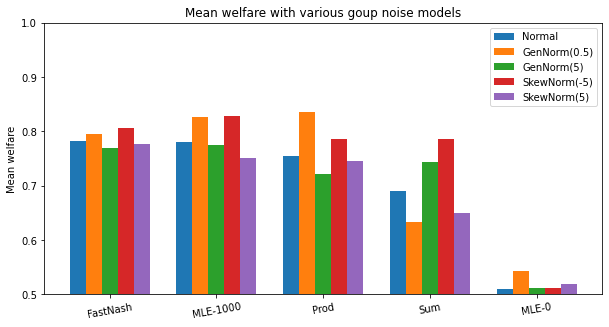

In [117]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, results_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Mean welfare")
plt.title("Mean welfare with various goup noise models")
plt.legend()
plt.show()

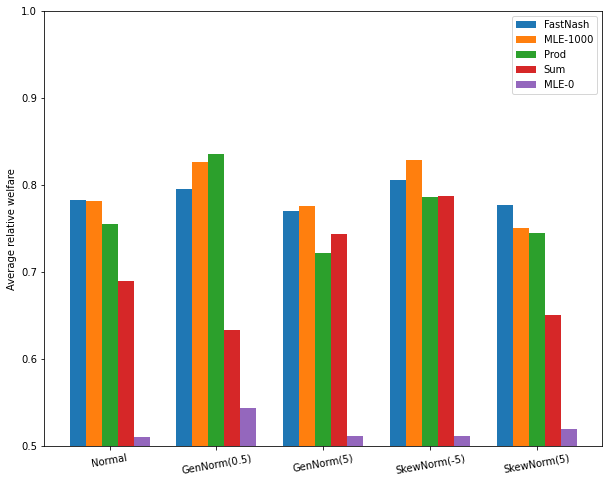

In [118]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 8))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, results_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Average relative welfare")
# plt.title("Mean welfare with various goup noise models")
plt.legend()
plt.show()

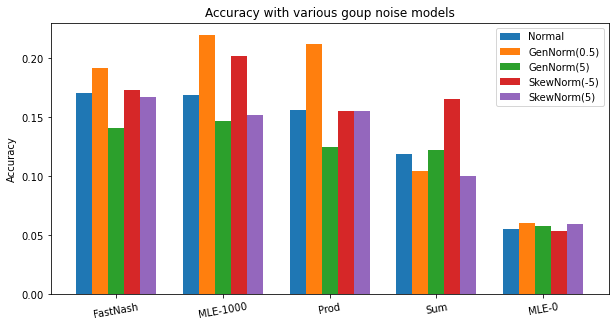

In [119]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, accuracy_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various goup noise models")
plt.legend()
plt.show()

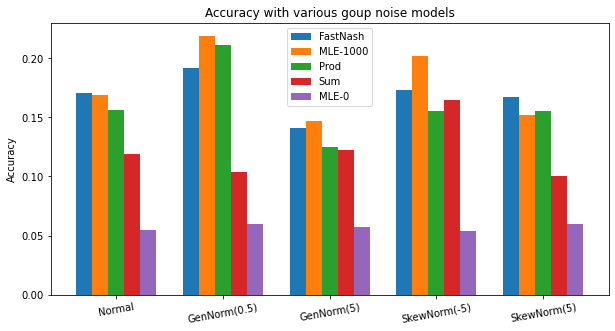

In [120]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, accuracy_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various goup noise models")
plt.legend()
plt.show()

# Fonction de bruit individuel

In [48]:
list_bruits = [np.random.normal, fpoisson(3), fpoissongauss(2,0.25), fpower(2), fpower(4)]
bruits_name = ["Normal", "Poisson(3)", "Poisson(2) + Gauss(0.25)", "Power(2)", "Power(4)"]

In [121]:
results_exp = np.zeros((len(list_bruits),len(list_agg)))
accuracy_exp = np.zeros((len(list_bruits),len(list_agg)))
for j,bruit in enumerate(list_bruits):
    groups_sizes = [20,1,1,1,1]
    features = np.eye(5)
    generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                          group_noise_f=np.random.normal,
                                                          independent_noise_f=bruit)
    for _ in tqdm(range(n_trys)):

        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        i = 20
        for agg in list_agg:
            agg.reset()


        ## training the MLE 500
        _ = list_agg[1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 2000/2000 [03:05<00:00, 10.78it/s]


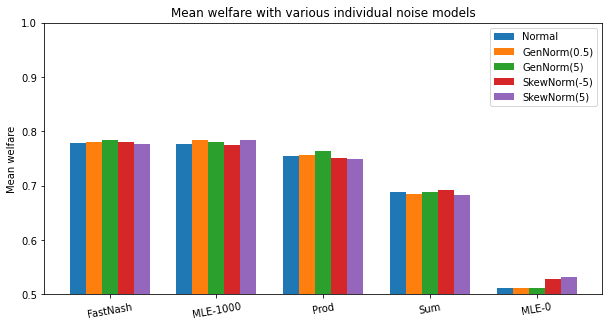

In [122]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, results_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Mean welfare")
plt.title("Mean welfare with various individual noise models")
plt.legend()
plt.show()

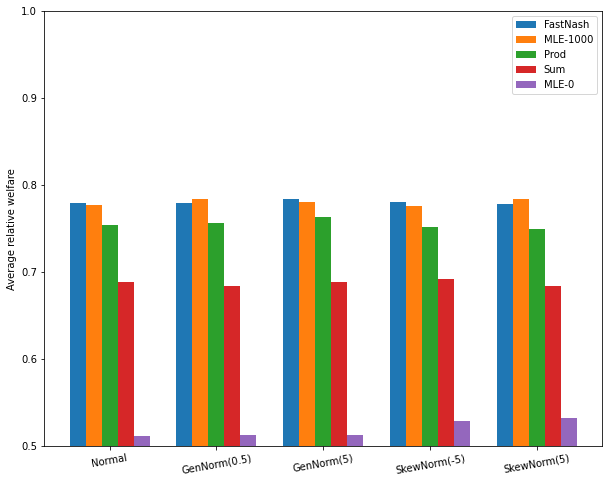

In [123]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 8))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, results_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Average relative welfare")
# plt.title("Mean welfare with various goup noise models")
plt.legend()
plt.show()

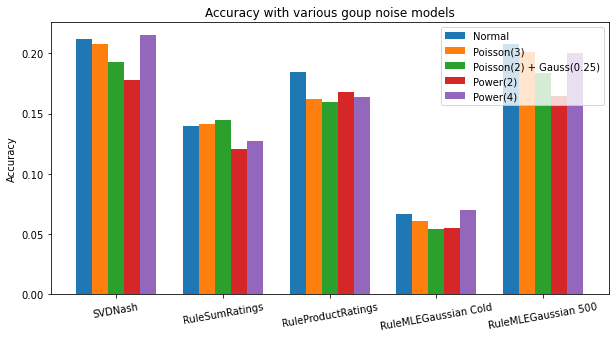

In [53]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, accuracy_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various goup noise models")
plt.legend()
plt.show()

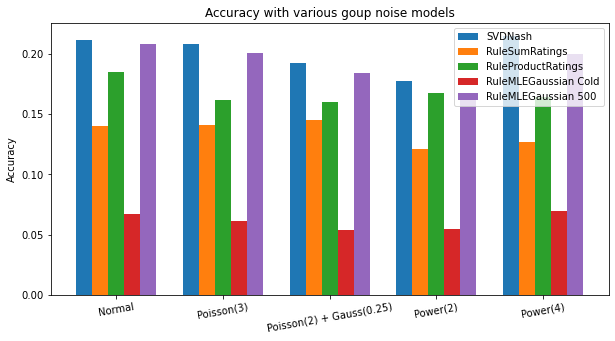

In [54]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, accuracy_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various goup noise models")
plt.legend()
plt.show()

# Fonction de génération de truth

In [269]:
f1 = lambda x: np.random.uniform(10,20,x)
f2 = lambda x:np.random.normal(15,2.89,x)
f3 = lambda x:(10+np.random.power(1,x)*10)
f4 = lambda x:(10+np.random.gamma(2.89**2,1,x))
f5 = lambda x:(10+np.random.gamma(1,2.89,x))
f6 = lambda x:(10+np.random.exponential(2.89,x))

In [270]:
class TruthGeneratorFunction(ev.TruthGenerator):
    def __init__(self, f):
        self.f = f

    def __call__(self, n_candidates):
        return self.f(n_candidates)
    



In [266]:
list_bruits = [ev.TruthGeneratorUniform(seed=42),  ev.TruthGeneratorNormal(15, 2), ev.TruthGeneratorNormal(20, 3), ev.TruthGeneratorPowerLaw(10, 20, 5), ev.TruthGeneratorPowerLaw(20, 50, 8)]
bruits_name = ["Uniform", "Normal (2)", "Normal (3)", "PowerLaw (5)", "PowerLaw (8)"]

In [271]:
list_bruits = [TruthGeneratorFunction(f1), TruthGeneratorFunction(f2),
              TruthGeneratorFunction(f3), TruthGeneratorFunction(f4),
              TruthGeneratorFunction(f5), TruthGeneratorFunction(f6)]

bruits_name = ["Uniform", "Normal", "PowerLaw", "Gamma 1", "Gamma 2", "Exponential"]

In [274]:
results_exp = np.zeros((len(list_bruits),len(list_agg)))
accuracy_exp = np.zeros((len(list_bruits),len(list_agg)))
for j,bruit in enumerate(list_bruits):
    groups_sizes = [20,1,1,1,1]
    features = np.eye(5)
    generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=bruit,
                                                          group_noise_f=np.random.normal,
                                                          independent_noise_f=np.random.normal)
    for _ in tqdm(range(n_trys)):

        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        i = 20
        for agg in list_agg:
            agg.reset()


        ## training the MLE 500
        _ = list_agg[1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]


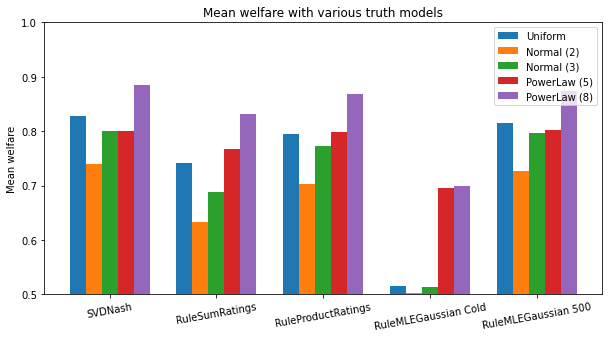

In [57]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, results_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Mean welfare")
plt.title("Mean welfare with various truth models")
plt.legend()
plt.show()

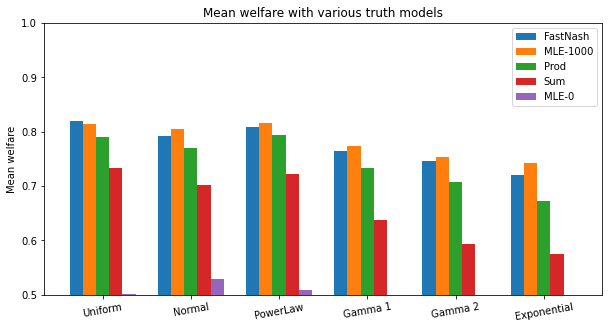

In [275]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, results_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0.5,1)
plt.ylabel("Mean welfare")
plt.title("Mean welfare with various truth models")
plt.legend()
plt.show()

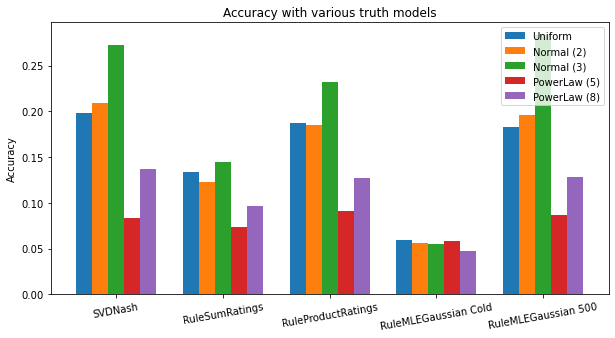

In [59]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(list_bruits)):
    plt.bar(np.arange(len(list_agg))-0.3+0.15*k, accuracy_exp[k], width= 0.15,label=bruits_name[k])
plt.xticks(np.arange(len(list_agg)), rules_names, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various truth models")
plt.legend()
plt.show()

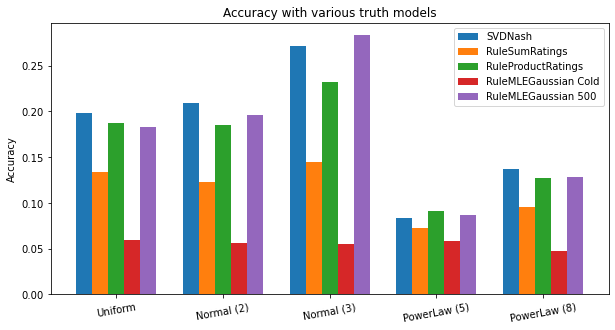

In [60]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(10, 5))
for k in range(len(rules_names)):
    plt.bar(np.arange(len(list_bruits))-0.3+0.15*k, accuracy_exp[:,k], width= 0.15,label=rules_names[k])
plt.xticks(np.arange(len(list_bruits)), bruits_name, rotation=10)

plt.ylim(0)
plt.ylabel("Accuracy")
plt.title("Accuracy with various truth models")
plt.legend()
plt.show()

# Scenario à groupe mixte

## Groupe general devient indépendant

In [5]:
def mymatrix(alpha):
    M = np.eye(24)
    for i in range(20):
        M[i] = [alpha**(np.abs(j-i)) for j in range(20)]+[0]*4
    return M


## Le coup de la diagonale

In [179]:
def mymatrix(n, alpha):
    M = np.zeros((n,n))
    for i in range(n):
        M[i] = [alpha**(np.abs(j-i)) for j in range(n)]
    return M

mymatrix(5,0.1)

array([[1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04],
       [1.e-01, 1.e+00, 1.e-01, 1.e-02, 1.e-03],
       [1.e-02, 1.e-01, 1.e+00, 1.e-01, 1.e-02],
       [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e-01],
       [1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]])

In [180]:
alphas = np.linspace(0,1,11)

In [181]:
results_exp = np.zeros((len(alphas),len(list_agg)))
accuracy_exp = np.zeros((len(alphas),len(list_agg)))
for j,alpha in enumerate(alphas):
    groups_sizes = [20,1,1,1,1]
    generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                          mymatrix(5,alpha), 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                          group_noise_f=np.random.normal,
                                                          independent_noise_f=np.random.normal)
    for _ in tqdm(range(n_trys)):

        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        i = 20
        for agg in list_agg:
            agg.reset()


        ## training the MLE 500
        _ = list_agg[1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


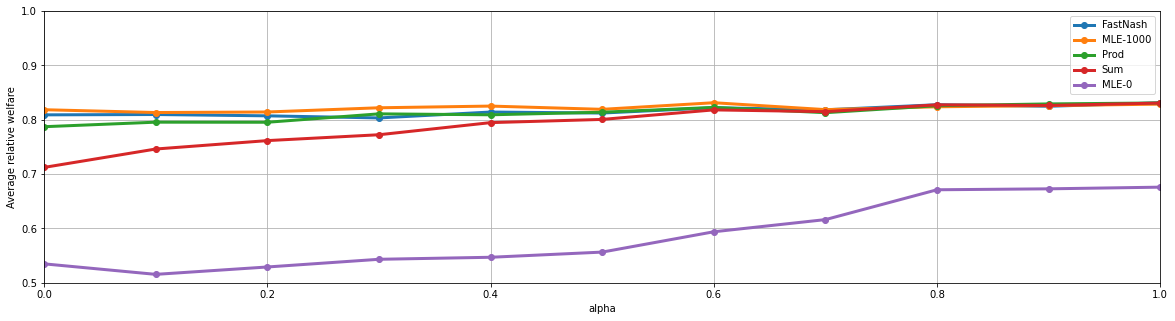

In [183]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for k in range(len(list_agg)):
    plt.plot(alphas, results_exp[:,k], 'o-', label=rules_names[k], linewidth=3)
plt.ylim(0.5,1)
plt.xlim(0,1)
plt.ylabel("Average relative welfare")
plt.xlabel("alpha")
# plt.title("Mean welfare with alpha power model")
plt.legend()
plt.grid(0.3)
plt.show()

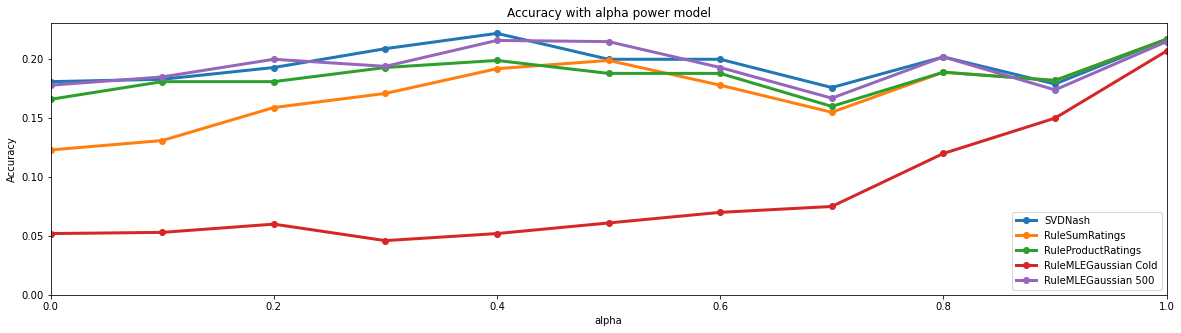

In [75]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for k in range(len(list_agg)):
    plt.plot(alphas, accuracy_exp[:,k], 'o-', label=rules_names[k], linewidth=3)
plt.ylim(0)
plt.xlim(0,1)
plt.ylabel("Accuracy")
plt.xlabel("alpha")
plt.title("Accuracy with alpha power model")
plt.legend()
plt.show()

Get better, idée : proba au lieu de weighted sum

## 1 groupe intermédiaire

In [79]:
def mymatrix2(n, alpha):
    M = np.eye(n)
    for i in range(1, n):
        M[i,0] = alpha
    return M

In [80]:
alphas = np.linspace(0,2,11)
results_exp = np.zeros((len(alphas),len(list_agg)))
accuracy_exp = np.zeros((len(alphas),len(list_agg)))
for j,alpha in enumerate(alphas):
    groups_sizes = [20,1,1,1,1]
    generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                          mymatrix2(5,alpha), 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=ev.TruthGeneratorUniform(seed=42),
                                                          group_noise_f=np.random.normal,
                                                          independent_noise_f=np.random.normal)
    for _ in tqdm(range(n_trys)):

        ratings_training = generator(500)
        ratings_training = np.maximum(ratings_training, 0)
        ratings_candidates = generator(n_candidates)
        ratings_candidates = np.maximum(ratings_candidates, 0)
        truth = generator.ground_truth_
        i = 20
        for agg in list_agg:
            agg.reset()


        ## training the MLE 500
        _ = list_agg[-1]( ratings_training).winner_

        welfare = ev.RuleSumRatings()(ev.Ratings([truth])).welfare_
        # getting the results

        for k,agg in enumerate(list_agg):
            w = agg(ratings_candidates).winner_
            results_exp[j][k] += welfare[w]
            if w == np.argmax(welfare):
                accuracy_exp[j][k] += 1

results_exp /= n_trys
accuracy_exp /= n_trys

100%|██████████| 1000/1000 [01:11<00:00, 13.94it/s]


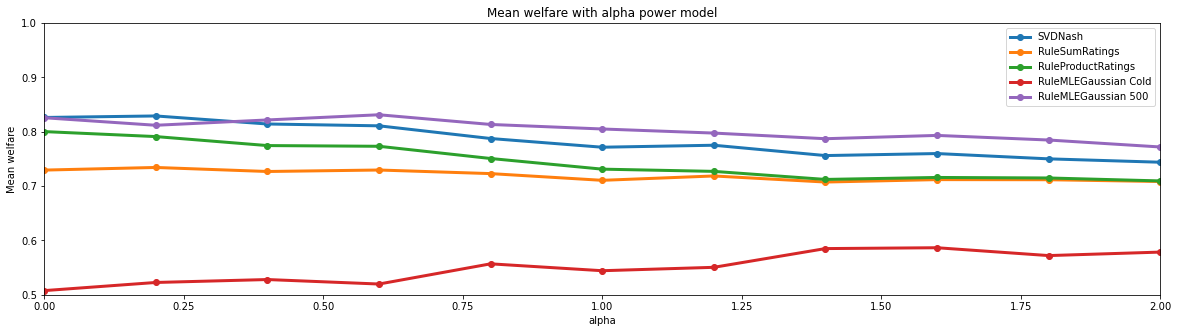

In [81]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for k in range(len(list_agg)):
    plt.plot(alphas, results_exp[:,k], 'o-', label=rules_names[k], linewidth=3)
plt.ylim(0.5,1)
plt.xlim(0,2)
plt.ylabel("Mean welfare")
plt.xlabel("alpha")
plt.title("Mean welfare with alpha power model")
plt.legend()
plt.show()

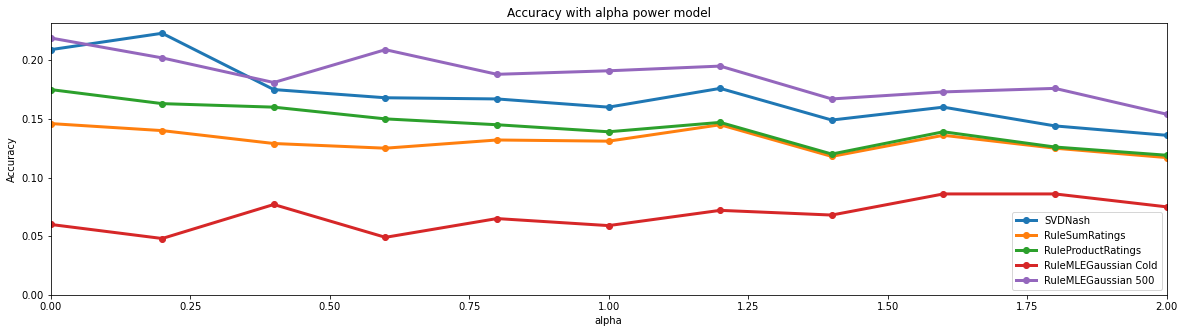

In [82]:
rules_names = [agg.name for agg in list_agg]
_ = plt.figure(figsize=(20, 5))
for k in range(len(list_agg)):
    plt.plot(alphas, accuracy_exp[:,k], 'o-', label=rules_names[k], linewidth=3)
plt.ylim(0)
plt.xlim(0,2)
plt.ylabel("Accuracy")
plt.xlabel("alpha")
plt.title("Accuracy with alpha power model")
plt.legend()
plt.show()

FIN

In [11]:
groups_sizes = [20,1,1,1,1]
features = np.eye(5)

generator = ev.RatingsGeneratorEpistemicGroupsMixFree(groups_sizes, 
                                                      features, 
                                                      group_noise=default_group_noise, 
                                                      independent_noise=default_indep_noise,
                                                          center_gap=0, 
                                                          max_scale=1,
                                                          truth_generator=ev.TruthGeneratorUniform(seed=np.random.randint(100000)),
                                                          group_noise_f=np.random.normal,
                                                          independent_noise_f=np.random.normal)


ag = ev.Aggregator(rule=ev.RuleRatingsHistory(rule=ev.RuleProductRatings()), name="Prod")
print(n_candidates)
ratings_candidates = generator(n_candidates)
s = ag(ratings_candidates).scores_
sorted(s)[::-1]

20


[(23, 4.162054124826404),
 (23, 3.646630359853392e-05),
 (23, 2.4569053434161194e-07),
 (22, 207.33007563440336),
 (22, 1.6621081446726966e-05),
 (21, 12.332097176595429),
 (21, 0.14958576960192452),
 (21, 0.00040847049167207515),
 (16, 2.4721135484598117e-08),
 (14, 7.011448134821767e-07),
 (14, 2.564184919263861e-07),
 (4, 0.30893845676110365),
 (4, 0.2613036829595805),
 (3, 0.681359158869047),
 (3, 0.6600423165380513),
 (2, 0.5067516297182076),
 (2, 0.25199153822369186),
 (2, 0.15988333633861027),
 (1, 0.9302812362187455),
 (0, 1.0)]

In [ ]:
def f(ratings_v, history_mean, history_std):
    return np.sqrt(np.maximum(0, (ratings_v - history_mean) / history_std))
        
ev.Ratings([
            f(ratings_v, history_mean, history_std)
            for ratings_v, history_mean, history_std in zip(ratings, history_means, history_stds)
])